# Исследование тарифных планов

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов
| Тариф             | Смарт               | Ультра  |
| :-----------------|:--------------------| :-------|
| Ежемесячная плата| 550 р. | 1950 р. |
| План     | 500 мин, 50 смс, 15 Гб      |   3000 мин, 1000 смс, 30 ГБ   |
| Стоимость услуг сверх плана* | мин - 3 р.; смс - 3 р.; 1 ГБ - 200 р. | мин - 1 р.; смс - 1 р.; 1 ГБ - 150 р.|

*«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Содержание
1. [Изучение данных](#data1)
2. [Подготовка данных к анализу](#data2)
3. [Анализ данных](#analysis)
4. [Проверка гипотез](#hypotheses)
5. [Общий вывод](#results)

## Изучение данных <a name="data1"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

In [2]:
# opening file calls
try:
    df_calls = pd.read_csv('/datasets/calls.csv') # Yandex path
except:
    df_calls = pd.read_csv('calls.csv') # personal path

display(df_calls.info())
display(df_calls.head())

# checking for duplicates
df_calls.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


0

In [3]:
# opening file internet
try:
    df_internet = pd.read_csv('/datasets/internet.csv') # Yandex path
except:
    df_internet = pd.read_csv('internet.csv') # personal path

display(df_internet.info())
display(df_internet.head())

# checking for duplicates
df_internet.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


0

In [4]:
# opening file messages
try:
    df_messages = pd.read_csv('/datasets/messages.csv') # Yandex path
except:
    df_messages = pd.read_csv('messages.csv') # personal path

display(df_messages.info())
display(df_messages.head())

# checking for duplicates
df_messages.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


0

In [5]:
# opening file tariffs
try:
    df_tariffs = pd.read_csv('/datasets/tariffs.csv') # Yandex path
except:
    df_tariffs = pd.read_csv('tariffs.csv') # personal path

display(df_tariffs.info())
df_tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [6]:
# opening file users
try:
    df_users = pd.read_csv('/datasets/users.csv') # Yandex path
except:
    df_users = pd.read_csv('users.csv') # personal path

display(df_users.info())
display(df_users.head())

# checking for duplicates
df_users.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


0

#### Вывод 

- Данные для анализа собраны в 5 разных датафреймах, для дальнейшей обработки необходимо будет собрать все данные в один датафрейм
- Первоначальная обработка обобщена в таблице ниже:

| Датафрейм | Необходимая обработка |
| :-----------------|:--------------------|
| df_calls| отформатировать даты в call_date и создать отдельный столбец с месяцами| 
| df_internet| отформатировать даты в session_date и создать отдельный столбец с месяцами| 
| df_internet| удалить столбец Unnamed: 0| 
| df_messages| отформатировать даты в message_date и создать отдельный столбец с месяцами| 
| df_tariffs| без изменений | 
| df_users| отформатировать даты в churn_date, пропуски оставляем как есть, ибо они не влияют на анализ| 

## Подготовка данных к анализу <a name="data2"></a>

#### Предобработка данных

In [7]:
# changing dates format
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')

In [8]:
# replacing dates to months in df_calls, df_internet, df_messages
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month

In [9]:
# deleting column in df_internet
df_internet.drop('Unnamed: 0', axis=1, inplace=True)

Предварительная предобработка данных завершена, можно переходить к созданию единого датафрейма

#### Создание единого датафрейма

In [10]:
# rounding up calls duration upwards
df_calls['duration_billed']= df_calls['duration'].apply(np.ceil)

# grouping df_calls by user_id and month
df_calls_grouped = df_calls.groupby(['user_id','month']).agg(
    {'duration':'sum', 'duration_billed':'sum', 'id':'count'}
).reset_index()
df_calls_grouped = df_calls_grouped.rename(columns={'id': 'calls_number', 'duration':'duration_fact'})

In [11]:
# grouping df_messages by user_id and month
df_messages_grouped = df_messages.groupby(['user_id','month']).agg({'id':'count'}).reset_index()
df_messages_grouped = df_messages_grouped.rename(columns={'id': 'messages_number'})

In [12]:
# grouping df_internet by user_id and month
df_internet_grouped = df_internet.groupby(['user_id','month']).agg({'mb_used':'sum'}).reset_index()

In [13]:
# merging tables to get unified dataframe
# merging df_users and df_tariffs
df_tariffs = df_tariffs.rename(columns={'tariff_name': 'tariff'})
df_user_tariff = df_users.merge(df_tariffs, on='tariff', how='left')

# merging df_user_tariff with df_calls_grouped, df_internet_grouped, df_messages_grouped
df_user_stats = df_internet_grouped.merge(df_calls_grouped, on=['user_id', 'month'], how='outer')
df_user_stats = df_user_stats.merge(df_messages_grouped, on=['user_id', 'month'], how='outer')
df_full = df_user_tariff.merge(df_user_stats, on='user_id', how='outer')
df_full.reset_index()
df_full.info()
display(df_full.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   age                    3216 non-null   int64         
 2   churn_date             189 non-null    datetime64[ns]
 3   city                   3216 non-null   object        
 4   first_name             3216 non-null   object        
 5   last_name              3216 non-null   object        
 6   reg_date               3216 non-null   object        
 7   tariff                 3216 non-null   object        
 8   messages_included      3216 non-null   int64         
 9   mb_per_month_included  3216 non-null   int64         
 10  minutes_included       3216 non-null   int64         
 11  rub_monthly_fee        3216 non-null   int64         
 12  rub_per_gb             3216 non-null   int64         
 13  rub

user_id                     0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
month                       2
mb_used                    13
duration_fact              42
duration_billed            42
calls_number               42
messages_number           499
dtype: int64

Есть пропуски в значениях для некоторых пользователей - это означает, что пользователи не пользовались данной услугой --> заменим пропуски в столбцах mb_used, duration_fact, duration_billed, calls_number, messages_number на 0 для дальнейших подсчетов выручки. Отдельно проверим 3 строки, где отсутсвует месяц

In [14]:
# replacing NaNs
columns_to_replace = [
    'mb_used',
    'duration_fact',
    'duration_billed',
    'calls_number',  
    'messages_number', 
]
    
for column in columns_to_replace:
    df_full[column] = df_full[column].fillna(0)

In [15]:
# checking rows with no month

df_full_filtered = df_full[(df_full['month'].isna())]   
df_full_filtered

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,...,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,mb_used,duration_fact,duration_billed,calls_number,messages_number
827,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,...,1950,150,1,1,NaN,0.0,0.0,0.0,0.0,0.0
2335,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,50,15360,...,550,200,3,3,NaN,0.0,0.0,0.0,0.0,0.0


2 пользователя (user_id 1128 и 1371) прекратили пользоваться тарифом в том же месяце, что и подключили, эти 2 строки можно убрать из анализа, ибо услуги не использовались, и выручка не генерировалась.

In [16]:
# droping 2 rows
df_full = df_full.dropna(subset=['month'])

Получена таблица с помесячной статистикой на каждого клиента, которая позволит высчитать выручку на клиента

#### Расчет выручки

In [17]:
# calcultaing 'extra' columns
df_full['extra_calls'] = df_full['duration_billed'] - df_full['minutes_included']
df_full['extra_calls'] = [0 if i < 0 else i for i in df_full['extra_calls']]

df_full['extra_messages'] = df_full['messages_number'] - df_full['messages_included']
df_full['extra_messages'] = [0 if i < 0 else i for i in df_full['extra_messages']]

df_full['extra_traffic'] = df_full['mb_used'] - df_full['mb_per_month_included']
df_full['extra_traffic'] = [0 if i < 0 else i for i in df_full['extra_traffic']]

# calculating revenue
df_full['revenue'] = (df_full['rub_monthly_fee'] 
                      + df_full['extra_calls'] * df_full['rub_per_minute'] 
                      + df_full['extra_messages'] * df_full['rub_per_message'] 
                      + np.ceil(df_full['extra_traffic']/1024) * df_full['rub_per_gb'])

#### Подготовка финальной таблицы для анализа
Для дальнейшего анализа данных нам больше не нужны вспомогательные столбцы, которые были использованы для расчета выручки, а также не нужны описательные столбцы по содержимому тарифов и именам клиентов

In [18]:
# droping columns
columns_to_delete = [
    'first_name',
    'last_name',
    'messages_included',
    'mb_per_month_included',
    'minutes_included',
    'rub_monthly_fee',
    'rub_per_gb',
    'rub_per_message',
    'rub_per_minute',
    'duration_billed',
    'extra_calls',
    'extra_messages',
    'extra_traffic'
 ]

for column in columns_to_delete:
    df_full.drop(column, axis=1, inplace=True)

In [19]:
display(df_full.pivot_table(index='tariff', values='user_id', aggfunc='count'))

,user_id
tariff,
smart,2229
ultra,985


#### Вывод 

- Таблица готова для анализа, содержит 985 строк по тарифу ultra и 2229 строк по тарифу smart

## Анализ данных <a name="analysis"></a>

Разобьем данные на 2 выборки по тарифу и проанализируем по отдельности

In [20]:
# creating subsets
columns_list = ['duration_fact', 'messages_number', 'mb_used', 'revenue']

df_full_ultra = df_full.query('tariff == "ultra"')
df_full_smart = df_full.query('tariff == "smart"')

display(df_full_ultra[columns_list].describe())
df_full_smart[columns_list].describe()

,duration_fact,messages_number,mb_used,revenue
count,985.000000,985.000000,985.000000,985.000000
mean,497.068223,49.363452,19468.805208,2070.152284
std,299.904152,47.804457,10087.170752,376.187114
min,0.000000,0.000000,0.000000,1950.000000
25%,267.750000,6.000000,11770.260000,1950.000000
50%,488.100000,38.000000,19308.010000,1950.000000
75%,711.470000,79.000000,26837.690000,1950.000000
max,1578.060000,224.000000,49745.690000,4800.000000


,duration_fact,messages_number,mb_used,revenue
count,2229.000000,2229.000000,2229.000000,2229.000000
mean,394.427026,33.384029,16208.386990,1289.973531
std,179.962207,28.227876,5870.476681,818.404367
min,0.000000,0.000000,0.000000,550.000000
25%,267.230000,10.000000,12643.010000,550.000000
50%,397.980000,28.000000,16506.840000,1023.000000
75%,515.070000,51.000000,20042.930000,1750.000000
max,1354.220000,143.000000,38552.450000,6770.000000


In [21]:
# calculating mean, var and std for duration_fact, messages_number, mb_used and revenue
print('Среднее количество минут разговора тарифа ultra', round(df_full_ultra['duration_fact'].mean(),2))
print('Среднее количество минут разговора тарифа smart', round(df_full_smart['duration_fact'].mean(),2))
print()
print('Дисперсия минут разговора тарифа ultra', round(np.var(df_full_ultra['duration_fact'], ddof=1),2))
print('Дисперсия минут разговора тарифа smart', round(np.var(df_full_smart['duration_fact'], ddof=1),2))
print()
print('Стандартное отклонение минут разговора тарифа ultra', round(np.std(df_full_ultra['duration_fact'], ddof=1),2))
print('Стандартное отклонение минут разговора тарифа smart', round(np.std(df_full_smart['duration_fact'], ddof=1),2))
print('---------')
print()

print('Среднее количество сообщений тарифа ultra', round(df_full_ultra['messages_number'].mean(),2))
print('Среднее количество сообщений тарифа smart', round(df_full_smart['messages_number'].mean(),2))
print()
print('Дисперсия сообщений тарифа ultra', round(np.var(df_full_ultra['messages_number'], ddof=1),2))
print('Дисперсия сообщений тарифа smart', round(np.var(df_full_smart['messages_number'], ddof=1),2))
print()
print('Стандартное отклонение сообщений тарифа ultra', round(np.std(df_full_ultra['messages_number'], ddof=1),2))
print('Стандартное отклонение сообщений тарифа smart', round(np.std(df_full_smart['messages_number'], ddof=1),2))
print('---------')
print()

print('Средний интернет трафик тарифа ultra', round(df_full_ultra['mb_used'].mean(),2))
print('Средний интернет трафик тарифа smart', round(df_full_smart['mb_used'].mean(),2))
print()
print('Дисперсия интернет трафика тарифа ultra', round(np.var(df_full_ultra['mb_used'], ddof=1),2))
print('Дисперсия интернет трафика тарифа smart', round(np.var(df_full_smart['mb_used'], ddof=1),2))
print()
print('Стандартное отклонение интернет трафика тарифа ultra', round(np.std(df_full_ultra['mb_used'], ddof=1),2))
print('Стандартное отклонение интернет трафика тарифа smart', round(np.std(df_full_smart['mb_used'], ddof=1),2))
print('---------')
print()

print('Средняя выручка тарифа ultra', round(df_full_ultra['revenue'].mean(),2))
print('Средняя выручка тарифа smart', round(df_full_smart['revenue'].mean(),2))
print()
print('Дисперсия выручки тарифа ultra', round(np.var(df_full_ultra['revenue'], ddof=1),2))
print('Дисперсия выручки тарифа smart', round(np.var(df_full_smart['revenue'], ddof=1),2))
print()
print('Стандартное отклонение выручки тарифа ultra', round(np.std(df_full_ultra['revenue'], ddof=1),2))
print('Стандартное отклонение выручки тарифа smart', round(np.std(df_full_smart['revenue'], ddof=1),2))

Среднее количество минут разговора тарифа ultra 497.07
Среднее количество минут разговора тарифа smart 394.43

Дисперсия минут разговора тарифа ultra 89942.5
Дисперсия минут разговора тарифа smart 32386.4

Стандартное отклонение минут разговора тарифа ultra 299.9
Стандартное отклонение минут разговора тарифа smart 179.96
---------

Среднее количество сообщений тарифа ultra 49.36
Среднее количество сообщений тарифа smart 33.38

Дисперсия сообщений тарифа ultra 2285.27
Дисперсия сообщений тарифа smart 796.81

Стандартное отклонение сообщений тарифа ultra 47.8
Стандартное отклонение сообщений тарифа smart 28.23
---------

Средний интернет трафик тарифа ultra 19468.81
Средний интернет трафик тарифа smart 16208.39

Дисперсия интернет трафика тарифа ultra 101751013.78
Дисперсия интернет трафика тарифа smart 34462496.46

Стандартное отклонение интернет трафика тарифа ultra 10087.17
Стандартное отклонение интернет трафика тарифа smart 5870.48
---------

Средняя выручка тарифа ultra 2070.15
Сре

<AxesSubplot:title={'center':'Распределение выручки по тарифам'}, ylabel='Frequency'>

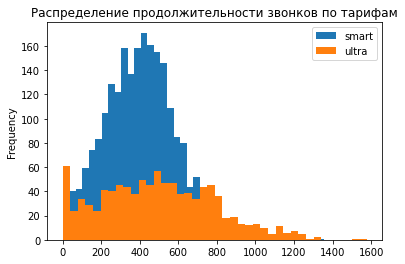

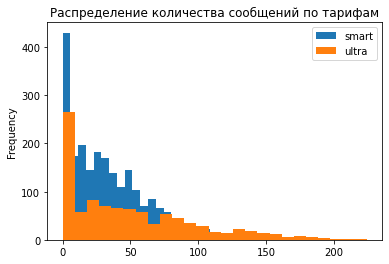

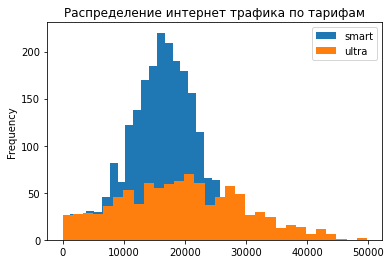

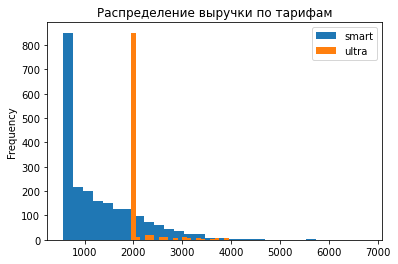

In [22]:
# histograms 

ax = df_full_smart.plot(
    kind='hist',
    y='duration_fact',
    bins=40,
    label='smart'
)

df_full_ultra.plot(
    kind='hist',
    y='duration_fact',
    bins=40,
    label='ultra',
    ax=ax,
    legend=True,
    title="Распределение продолжительности звонков по тарифам"
)

ax2 = df_full_smart.plot(
    kind='hist',
    y='messages_number',
    bins=25,
    label='smart'
)

df_full_ultra.plot(
    kind='hist',
    y='messages_number',
    bins=25,
    label='ultra',
    ax=ax2,
    legend=True,
    title="Распределение количества сообщений по тарифам"
)

ax3 = df_full_smart.plot(
    kind='hist',
    y='mb_used',
    bins=30,
    label='smart'
)

df_full_ultra.plot(
    kind='hist',
    y='mb_used',
    bins=30,
    label='ultra',
    ax=ax3,
    legend=True,
    title="Распределение интернет трафика по тарифам"
)

ax4 = df_full_smart.plot(
    kind='hist',
    y='revenue',
    bins=30,
    label='smart'
)

df_full_ultra.plot(
    kind='hist',
    y='revenue',
    bins=30,
    label='ultra',
    ax=ax4,
    legend=True,
    title="Распределение выручки по тарифам"
)

Диаграммы размаха для тарифа smart


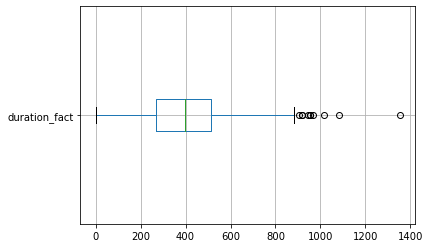

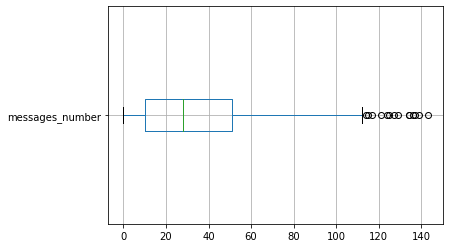

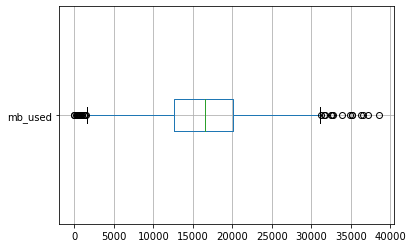

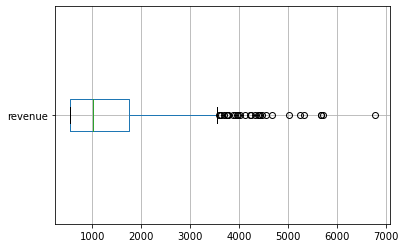

Диаграммы размаха для тарифа ultra


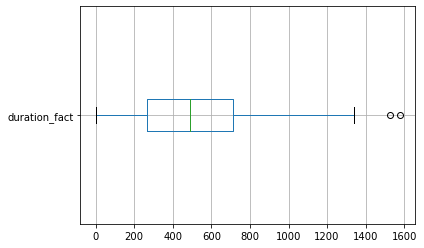

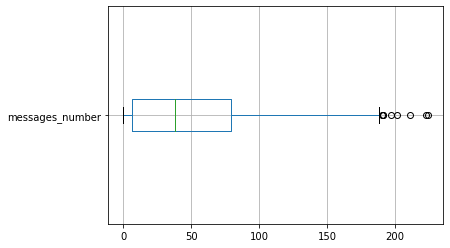

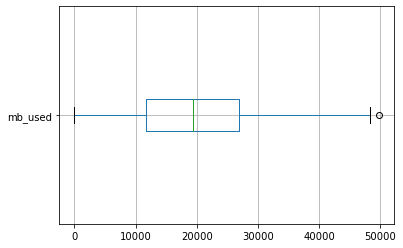

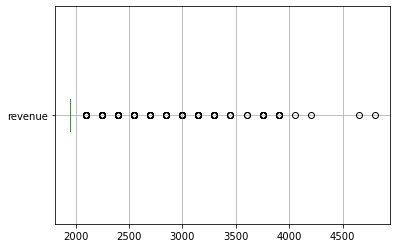

In [23]:
# boxplots
print('Диаграммы размаха для тарифа smart')
for column in columns_list:
    df_full_smart.boxplot(column, vert=False)
    plt.show() 
    
print('Диаграммы размаха для тарифа ultra')
for column in columns_list:
    df_full_ultra.boxplot(column, vert=False)
    plt.show()

   

#### Вывод
- Клиенты тарифа ultra потребляют больше минут, сообщений и интернета, если сравнивать по средней 
- Ввиду более высокой абонентской платы, средняя выручка в месяц с клиента по тарифу ultra выше
- Интересно то, что значительно большая часть клиентов тарифа ultra умещается в услугах, предоставленных планом - 75% данных по выручке соответствуют значению месячной абонентской платы (1950 рублей). Медианное значение выручки для клиентов тарифа smart почти в два раза превышает абонентскую плату (1023 рублей vs 550 рублей). 
- Распределение продолжительности звонков для тарифа smart похоже на нормальное распределение
- Распределение продолжительности звонков для тарифа ultra немного скошено вправо
- Распределение количества сообщений для обоих тарифов скошено вправо
- Распределение интернет трафика для обоих тарифов похоже на нормальное распределение
- Распределение выручки для обоих тарифов очень сильно скошено вправо

## Проверка гипотез <a name="hypotheses"></a>

#### Гипотеза 1: средняя выручка тарифов ultra и smart различаются:
 - H0 = средняя выручка тарифа ultra равна средней выручке тарифа smart
 - H1 = средние выручки не равны

Выборки из одной и той же генеральной совокупности, поэтому оценивать дисперсию будем по объединенному датасету

Проверяем гипотезу о равенстве, поэтому будем делать двусторонний тест

In [24]:
# checking hypothesis 1

array_ultra = df_full_ultra['revenue']
array_smart = df_full_smart['revenue']

alpha = 0.05

results = st.ttest_ind(array_ultra, array_smart, equal_var = True) 

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


В результате теста мы отвергаем нулевую гипотезу, то есть средние выручки отличаются. Действительно, выше мы получили следующие средние значения выручки:
- smart - 1290 рублей
- ultra - 2070 рубль

#### Гипотеза 2: средняя выручка в Москве отличается от выручки в регионах:
 - H0 = средняя выручка в Москве равна средней выручке в регионах
 - H1 = средние выручки не равны

Аналогично предыдущей гипотезе, выборки из одной и той же генеральной совокупности, поэтому оценивать дисперсию будем по объединенному датасету, и будем делать двусторонний тест

In [25]:
# checking hypothesis 2

df_full_moscow = df_full.query('city == "Москва"')
df_full_regions = df_full.query('city != "Москва"')

array_moscow = df_full_moscow['revenue']
array_regions = df_full_regions['revenue']

alpha2 = 0.05

results2 = st.ttest_ind(array_moscow, array_regions, equal_var = True) 

print('p-value:', results2.pvalue)

if results2.pvalue < alpha2:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print()    
print('Средняя выручка в Москве', round(df_full_moscow['revenue'].mean(),2))
print('Средняя выручка в регионах', round(df_full_regions['revenue'].mean(),2))

p-value: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу

Средняя выручка в Москве 1546.71
Средняя выручка в регионах 1524.94


В результате теста мы не отвергаем нулевую гипотезу, значения средних также говорят в пользу возможного равенства средних выручек в Москве и регионах

#### Гипотеза 3: средняя выручка тарифа ultra выше средней выручки тарифа smart
Принимая во внимание задачу исследования (какой тариф приносит больше выручки), проверим еще одну гипотезу

 - H0 = средняя выручка тарифа ultra равна средней выручке тарифа smart
 - H1 = средняя выручка тарифа ultra больше средней выручки тарифа smart

Аналогично предыдущим гипотезам, выборки из одной и той же генеральной совокупности, поэтому оценивать дисперсию будем по объединенному датасету, но в этот раз будем делать односторонний тест

In [26]:
results3 = st.ttest_ind(array_ultra, array_smart, equal_var = True) 

print('p-value:', results3.pvalue/2)

if results3.pvalue/2 < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 7.114907180382033e-161
Отвергаем нулевую гипотезу


В результате теста мы отвергаем нулевую гипотезу, еще раз подтверждая что средние выручки не равны, при этом в этот раз альтернативная гипотеза гласила, что средняя выручка тарифа ultra больше средней выручки тарифа smart. Мы можем сказать, что это вполне возможно



## Общий вывод <a name="results"></a>

- Ввиду более высокой абонентской платы, средняя выручка в месяц с клиента по тарифу ultra выше. Статистический анализ этого не отвергает, можно сказать, что с точки зрения генерирующейся выручки тариф ultra для компании лучше тарифа smart
- Клиенты тарифа ultra потребляют больше минут, сообщений и интернета, если сравнивать по средней 
- Интересно то, что значительно большая часть клиентов тарифа ultra умещается в услугах, предоставленных планом - при этом половина пользователей тарифа smart переплачивает почти в 2 раза больше, чем месячная плата, что говорит о том, что им не хватает предложенного плана